# Import Pakege

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os

# 디바이스 선언
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.cuda.empty_cache()

cuda


# Data

## Dataset Class

### Train/Val

In [2]:
import xml.etree.ElementTree as ET

# 클래스 매핑
CLASS_MAPPING = {"cat": 1, "dog": 2}

class PetDataset(Dataset):
    def __init__(self, data_dir, txt_file, transform=None, target_size=(300, 300)):
        """
        Oxford-IIIT Pet Dataset을 위한 PyTorch Dataset 클래스 (Bounding Box 포함)
        """
        self.data_dir = data_dir
        self.image_dir = os.path.join(data_dir, "images")
        self.anno_dir = os.path.join(data_dir, "annotations", "xmls")
        self.transform = transform
        self.target_size = target_size  # (300, 300) 고정
        self.image_list = []

        # 유효한 이미지 & XML만 리스트에 추가
        with open(txt_file, "r") as f:
            for line in f.readlines():
                img_name = line.strip().split()[0] + ".jpg"
                xml_name = img_name.replace(".jpg", ".xml")

                img_path = os.path.join(self.image_dir, img_name)
                xml_path = os.path.join(self.anno_dir, xml_name)

                # 이미지와 XML 파일이 모두 존재하는 경우만 추가
                if os.path.exists(img_path) and os.path.exists(xml_path):
                    self.image_list.append(img_name)

        print(f"학습 데이터 개수: {len(self.image_list)}개 (필터링 완료)")

    def parse_annotation(self, xml_file, original_size):
        """
        XML 어노테이션 파일을 파싱하여 Bounding Box 및 클래스 라벨 정보 반환 (리사이징 반영)
        """
        tree = ET.parse(xml_file)
        root = tree.getroot()
        width_orig, height_orig = original_size  # 원본 이미지 크기

        width_scale = self.target_size[0] / width_orig
        height_scale = self.target_size[1] / height_orig

        objects = []
        labels = []

        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text) * width_scale
            ymin = int(bbox.find("ymin").text) * height_scale
            xmax = int(bbox.find("xmax").text) * width_scale
            ymax = int(bbox.find("ymax").text) * height_scale
            objects.append([xmin, ymin, xmax, ymax])

            # 객체의 클래스명 가져오기 (cat or dog)
            class_name = obj.find("name").text.lower()
            labels.append(CLASS_MAPPING.get(class_name, 1))  # 기본값 cat(1)

        return objects, labels

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        # 이미지 로드
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"이미지 파일이 존재하지 않습니다: {img_path}")

        image = Image.open(img_path).convert("RGB")
        original_size = image.size  # (width, height)

        # 어노테이션 로드
        xml_name = img_name.replace(".jpg", ".xml")
        xml_path = os.path.join(self.anno_dir, xml_name)

        if os.path.exists(xml_path):
            bboxes, class_labels = self.parse_annotation(xml_path, original_size)
        else:
            bboxes, class_labels = [], []

        # SSD 학습을 위한 `targets` 변환 (배치 데이터 구조 수정)
        boxes = torch.tensor(bboxes, dtype=torch.float32).to(device) if len(bboxes) > 0 else torch.zeros((0, 4), dtype=torch.float32).to(device)
        labels = torch.tensor(class_labels, dtype=torch.int64).to(device) if len(class_labels) > 0 else torch.zeros((0,), dtype=torch.int64).to(device)

        targets = {"boxes": boxes, "labels": labels}

        # 이미지 변환 적용
        if self.transform:
            image = self.transform(image)

        return image, targets

### Test

In [3]:
class TestPetDataset(Dataset):
    def __init__(self, data_dir, txt_file, transform=None):
        """
        Oxford-IIIT Pet Dataset을 위한 테스트용 PyTorch Dataset 클래스 (Bounding Box 없음)
        :param data_dir: 데이터가 저장된 최상위 폴더 경로
        :param txt_file: test.txt 파일 경로
        :param transform: 이미지 변환 (Torchvision Transform)
        """
        self.data_dir = data_dir
        self.image_dir = os.path.join(data_dir, "images")
        self.transform = transform
        self.image_list = []

        # 존재하는 이미지 파일만 리스트에 추가
        with open(txt_file, "r") as f:
            for line in f.readlines():
                img_name = line.strip().split()[0] + ".jpg"
                img_path = os.path.join(self.image_dir, img_name)

                if os.path.exists(img_path):
                    self.image_list.append(img_name)

        print(f"테스트 데이터 개수: {len(self.image_list)}개 (필터링 완료)")

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        # 이미지 로드
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"이미지 파일이 존재하지 않습니다: {img_path}")

        image = Image.open(img_path).convert("RGB")

        # 변환 적용
        if self.transform:
            image = self.transform(image)

        return image, img_name  # 테스트셋에서는 파일명도 함께 반환

## Transform

In [4]:
# SSD 모델을 위한 데이터 변환 설정
transform = transforms.Compose([
    transforms.Resize((300, 300)),  # SSD 입력 사이즈
    transforms.ToTensor()
])

## Dataset 생성

In [5]:
# 데이터 경로
data_root = r"E:\python\data\SSD"

# 데이터셋 로드
# 전체 trainval dataset 로드
trainval_dataset = PetDataset(data_root, os.path.join(data_root, "annotations", "trainval.txt"), transform=transform)

# Train/Validation Split (80:20)
train_size = int(0.8 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size
train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

test_dataset = TestPetDataset(data_root, os.path.join(data_root, "annotations", "test.txt"), transform=transform)

# 데이터 확인
print(f"Train Dataset 크기: {len(train_dataset)}")
print(f"Val Dataset 크기: {len(val_dataset)}")
print(f"Test Dataset 크기: {len(test_dataset)}")

학습 데이터 개수: 3671개 (필터링 완료)
테스트 데이터 개수: 3669개 (필터링 완료)
Train Dataset 크기: 2936
Val Dataset 크기: 735
Test Dataset 크기: 3669


## 시각화

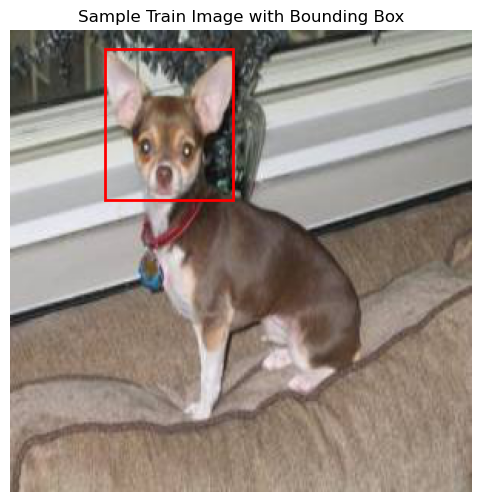

In [6]:
# 데이터셋에서 첫 번째 이미지 & 타겟 가져오기
sample_image, sample_target = train_dataset[0]  # 첫 번째 데이터 샘플 사용
boxes = sample_target["boxes"].cpu().numpy()  # 바운딩 박스 좌표 (Tensor → NumPy)

# 이미지 변환 (Tensor → NumPy)
sample_image = sample_image.permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)
sample_image = np.clip(sample_image, 0, 1)  # 값 범위를 [0,1]로 조정

# Bounding Box 좌표 가져오기
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.imshow(sample_image)

# 바운딩 박스 그리기
for bbox in boxes:
    xmin, ymin, xmax, ymax = bbox
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                         linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

plt.title("Sample Train Image with Bounding Box")
plt.axis("off")
plt.show()

시각화를 통해 이미지 리사이징에 맞게 바운딩 박스의 좌표도 잘 수정되었는지 확인

## Data Loader

In [7]:
def collate_fn(batch):
    """
    DataLoader에서 SSD 모델이 요구하는 `targets` 형태를 유지하기 위한 함수.
    - `images`: 텐서 리스트 (batch 형태 유지)
    - `targets`: 리스트 (batch 단위로 묶이지 않도록)
    """
    images, targets = zip(*batch)  # 이미지와 타겟을 분리

    images = torch.stack(images, dim=0)  # 이미지들은 배치 단위로 스택 쌓기
    return images, list(targets)  # targets는 리스트 형태 유지 (batch 단위로 묶이지 않게)

batch_size = 16

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"Train Loader 크기: {len(train_loader)}")
print(f"Val Loader 크기: {len(val_loader)}")
print(f"Test Loader 크기: {len(test_loader)}")

for images, bboxes in train_loader:
    print(f"Batch 이미지 크기: {images.shape}")  # (batch, 3, 300, 300)
    print(f"Bounding Boxes: {bboxes}")  # 각 이미지의 bounding box 리스트
    break

Train Loader 크기: 184
Val Loader 크기: 46
Test Loader 크기: 230
Batch 이미지 크기: torch.Size([16, 3, 300, 300])
Bounding Boxes: [{'boxes': tensor([[ 13.5135,  70.8000, 247.7477, 237.0000]], device='cuda:0'), 'labels': tensor([2], device='cuda:0')}, {'boxes': tensor([[123.0000, 101.6000, 177.0000, 168.8000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0')}, {'boxes': tensor([[169.8000,  22.4138, 246.0000, 143.9655]], device='cuda:0'), 'labels': tensor([1], device='cuda:0')}, {'boxes': tensor([[  2.3936,   9.6000, 225.0000, 184.2000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0')}, {'boxes': tensor([[147.9564,  31.2000, 297.5477, 142.8000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 58.2000,  54.0541, 168.0000, 210.8108]], device='cuda:0'), 'labels': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 19.2000,  70.2000, 115.2000, 120.0000]], device='cuda:0'), 'labels': tensor([2], device='cuda:0')}, {'boxes': tensor([[133.8000,   0.8000, 2

# Modeling

## SSD Model Load

In [50]:
import torchvision
from torchvision.models.detection.ssd import SSD300_VGG16_Weights

def get_model(num_classes=3):
    # SSD 모델 로드 (Pretrained)
    model = torchvision.models.detection.ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)

    # 모델의 클래스 수 수정
    model.head.classification_head.num_classes = num_classes

    return model.to(device)

print("SSD 모델 준비 완료")

SSD 모델 준비 완료


## Early Stopping Class

In [51]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0001, verbose=False, path='best_model.pth'):
        """
        patience: 개선이 없을 경우 종료까지 기다릴 에폭 수
        delta: 최소 개선 값
        verbose: 모델 저장 여부를 출력할지 여부
        path: 모델 저장 경로
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_score = -float("inf")  # 초기값을 -무한대로 설정
        self.early_stop = False

    def __call__(self, score, model):
        """검증 점수를 기준으로 Early Stopping 수행"""
        if self.patience == 0:
            self.save_checkpoint(model)  # 모델 저장
            return

        if score > self.best_score + self.delta:  # 스코어가 개선되었으면
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0  # 카운터 초기화
        else:  # 개선되지 않았으면 카운터 증가
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        """Validation 점수가 개선될 때 모델 저장"""
        if self.verbose:
            print(f"Best score improved to {self.best_score:.4f}. Saving model...")
        torch.save(model.state_dict(), self.path)


## 검증 함수

In [52]:
def evaluate_model(model, val_loader, device="cuda"):
    model.eval()
    max_scores = []

    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            pre = model(images)

            for p in pre:
                scores = p['scores'].cpu().numpy()
                if len(scores) > 0:
                    max_scores.append(float(max(scores)))
                else:
                    max_scores.append(0.0)

    return float(sum(max_scores)) / len(max_scores) if len(max_scores) > 0 else 0.0

## 학습 함수

In [53]:
from tqdm import tqdm

def train_model(model, optimizer, num_epochs=10, step_size=5, gamma=0.1, es=True, patience=5, delta=0.0001, path='best_SSD_model.pth'):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma) 
    early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True, path=path)

    train_losses = []
    val_scores = []
    
    # 학습 시작
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        
        for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = [img.to(device) for img in images]  # 이미지 변환
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # 바운딩 박스 및 라벨을 GPU로 이동

            optimizer.zero_grad()
            loss_dict = model(images, targets)  # SSD 모델 학습
            loss = sum(loss for loss in loss_dict.values())  # 총 손실 계산
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        scheduler.step()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        val_score = evaluate_model(model, val_loader)
        val_scores.append(val_score)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Score: {val_score:.4f}")

        if es:
            early_stopping(val_score, model)  # 검증 점수를 기준으로 조기 종료 확인
            if early_stopping.early_stop:  
                print("Early stopping activated")
                break  # 학습 중단
    
    return train_losses, val_scores

## Optimizer 비교

### 학습

In [54]:
# 학습 설정
num_epochs = 10

# 옵티마이저 설정
optimizers = {
    "SGD": optim.SGD,
    "AdamW": optim.AdamW
}

# 결과 저장
results = {}

for opt_name, optimizer_class in optimizers.items():
    print(f"\n학습 시작: {opt_name}")

    # 모델 & 옵티마이저 초기화
    model = get_model()
    optimizer = optimizer_class(model.parameters(), lr=0.001 if opt_name == "SGD" else 0.0001, weight_decay=5e-4)
    train_losses, val_scores = train_model(model, optimizer, num_epochs, es=False)
    del model

    # 결과 저장
    results[opt_name] = {
        "train_loss": train_losses,
        "val_score": val_scores
    }

print("\n옵티마이저 비교 학습 완료")


학습 시작: SGD


Epoch 1/10: 100%|██████████| 184/184 [01:37<00:00,  1.89it/s]


Epoch 1/10 - Train Loss: 2.3491, Val Score: 0.8970


Epoch 2/10: 100%|██████████| 184/184 [01:37<00:00,  1.89it/s]


Epoch 2/10 - Train Loss: 1.4492, Val Score: 0.9275


Epoch 3/10: 100%|██████████| 184/184 [01:36<00:00,  1.91it/s]


Epoch 3/10 - Train Loss: 1.2126, Val Score: 0.9379


Epoch 4/10: 100%|██████████| 184/184 [01:36<00:00,  1.91it/s]


Epoch 4/10 - Train Loss: 1.0824, Val Score: 0.9514


Epoch 5/10: 100%|██████████| 184/184 [01:36<00:00,  1.91it/s]


Epoch 5/10 - Train Loss: 0.9525, Val Score: 0.9568


Epoch 6/10: 100%|██████████| 184/184 [01:36<00:00,  1.90it/s]


Epoch 6/10 - Train Loss: 0.8246, Val Score: 0.9640


Epoch 7/10: 100%|██████████| 184/184 [01:37<00:00,  1.90it/s]


Epoch 7/10 - Train Loss: 0.8080, Val Score: 0.9644


Epoch 8/10: 100%|██████████| 184/184 [01:36<00:00,  1.90it/s]


Epoch 8/10 - Train Loss: 0.7987, Val Score: 0.9654


Epoch 9/10: 100%|██████████| 184/184 [01:37<00:00,  1.89it/s]


Epoch 9/10 - Train Loss: 0.7892, Val Score: 0.9681


Epoch 10/10: 100%|██████████| 184/184 [01:36<00:00,  1.91it/s]


Epoch 10/10 - Train Loss: 0.7797, Val Score: 0.9660

학습 시작: AdamW


Epoch 1/10: 100%|██████████| 184/184 [01:38<00:00,  1.86it/s]


Epoch 1/10 - Train Loss: 2.1817, Val Score: 0.9261


Epoch 2/10: 100%|██████████| 184/184 [01:38<00:00,  1.86it/s]


Epoch 2/10 - Train Loss: 1.1355, Val Score: 0.9345


Epoch 3/10: 100%|██████████| 184/184 [01:38<00:00,  1.87it/s]


Epoch 3/10 - Train Loss: 0.8421, Val Score: 0.9753


Epoch 4/10: 100%|██████████| 184/184 [01:39<00:00,  1.85it/s]


Epoch 4/10 - Train Loss: 0.6425, Val Score: 0.9628


Epoch 5/10: 100%|██████████| 184/184 [01:39<00:00,  1.86it/s]


Epoch 5/10 - Train Loss: 0.5012, Val Score: 0.9848


Epoch 6/10: 100%|██████████| 184/184 [01:39<00:00,  1.85it/s]


Epoch 6/10 - Train Loss: 0.3261, Val Score: 0.9866


Epoch 7/10: 100%|██████████| 184/184 [01:40<00:00,  1.84it/s]


Epoch 7/10 - Train Loss: 0.2560, Val Score: 0.9887


Epoch 8/10: 100%|██████████| 184/184 [01:39<00:00,  1.85it/s]


Epoch 8/10 - Train Loss: 0.2248, Val Score: 0.9893


Epoch 9/10: 100%|██████████| 184/184 [01:38<00:00,  1.86it/s]


Epoch 9/10 - Train Loss: 0.2006, Val Score: 0.9901


Epoch 10/10: 100%|██████████| 184/184 [01:38<00:00,  1.86it/s]


Epoch 10/10 - Train Loss: 0.1803, Val Score: 0.9898

옵티마이저 비교 학습 완료


### 시각화

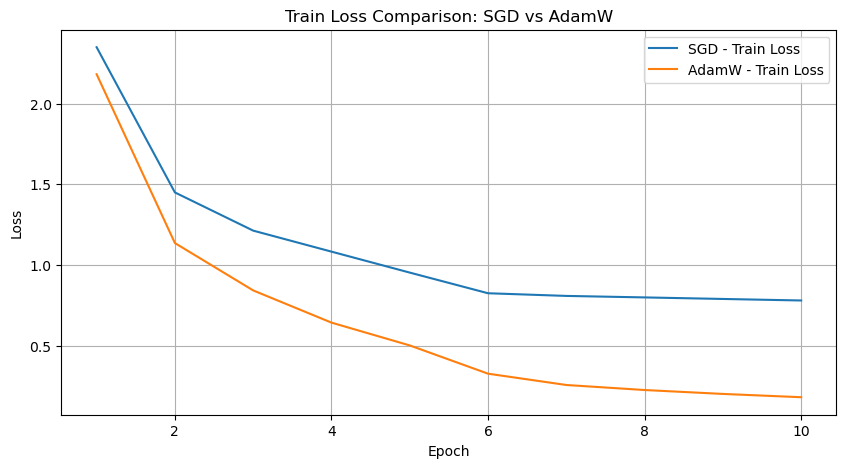

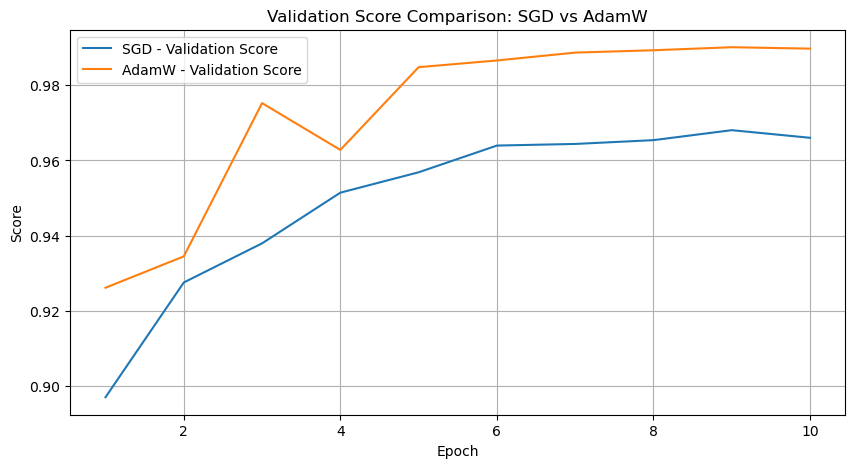

In [55]:
# 저장된 옵티마이저별 학습 및 검증 로스 가져오기
sgd_train_loss = results["SGD"]["train_loss"]
sgd_val_score = results["SGD"]["val_score"]
adamw_train_loss = results["AdamW"]["train_loss"]
adamw_val_score = results["AdamW"]["val_score"]

# 에포크 수 계산
epochs = range(1, len(sgd_train_loss) + 1)

# 학습 로스 시각화
plt.figure(figsize=(10, 5))
plt.plot(epochs, sgd_train_loss, label="SGD - Train Loss", linestyle="-")
plt.plot(epochs, adamw_train_loss, label="AdamW - Train Loss", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss Comparison: SGD vs AdamW")
plt.legend()
plt.grid()
plt.show()

# 검증 로스 시각화
plt.figure(figsize=(10, 5))
plt.plot(epochs, sgd_val_score, label="SGD - Validation Score", linestyle="-")
plt.plot(epochs, adamw_val_score, label="AdamW - Validation Score", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Score Comparison: SGD vs AdamW")
plt.legend()
plt.grid()
plt.show()

AdamW가 전체적으로 더 우수한 성능을 보여주기 때문에 AdamW 사용

## 설정

In [56]:
num_epochs = 50
step_size = 5
gamma = 0.1
es = True
patience = 5
delta = 0.0001
path = 'best_SSD_model.pth'

model = get_model()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5e-4)

## SSD Model 학습

In [57]:
train_losses, val_scores = train_model(model, optimizer, num_epochs=num_epochs, step_size=step_size, gamma=gamma, es=es, patience=patience, delta=delta, path=path)
del model

Epoch 1/50: 100%|██████████| 184/184 [01:40<00:00,  1.84it/s]


Epoch 1/50 - Train Loss: 2.1783, Val Score: 0.9369
Best score improved to 0.9369. Saving model...


Epoch 2/50: 100%|██████████| 184/184 [01:39<00:00,  1.85it/s]


Epoch 2/50 - Train Loss: 1.1528, Val Score: 0.9602
Best score improved to 0.9602. Saving model...


Epoch 3/50: 100%|██████████| 184/184 [01:39<00:00,  1.84it/s]


Epoch 3/50 - Train Loss: 0.8314, Val Score: 0.9691
Best score improved to 0.9691. Saving model...


Epoch 4/50: 100%|██████████| 184/184 [01:40<00:00,  1.83it/s]


Epoch 4/50 - Train Loss: 0.6199, Val Score: 0.9699
Best score improved to 0.9699. Saving model...


Epoch 5/50: 100%|██████████| 184/184 [01:39<00:00,  1.85it/s]


Epoch 5/50 - Train Loss: 0.5989, Val Score: 0.9783
Best score improved to 0.9783. Saving model...


Epoch 6/50: 100%|██████████| 184/184 [01:42<00:00,  1.80it/s]


Epoch 6/50 - Train Loss: 0.3516, Val Score: 0.9861
Best score improved to 0.9861. Saving model...


Epoch 7/50: 100%|██████████| 184/184 [01:41<00:00,  1.81it/s]


Epoch 7/50 - Train Loss: 0.2774, Val Score: 0.9875
Best score improved to 0.9875. Saving model...


Epoch 8/50: 100%|██████████| 184/184 [01:40<00:00,  1.84it/s]


Epoch 8/50 - Train Loss: 0.2442, Val Score: 0.9886
Best score improved to 0.9886. Saving model...


Epoch 9/50: 100%|██████████| 184/184 [01:39<00:00,  1.86it/s]


Epoch 9/50 - Train Loss: 0.2178, Val Score: 0.9890
Best score improved to 0.9890. Saving model...


Epoch 10/50: 100%|██████████| 184/184 [01:39<00:00,  1.86it/s]


Epoch 10/50 - Train Loss: 0.1965, Val Score: 0.9888
EarlyStopping counter: 1 out of 5


Epoch 11/50: 100%|██████████| 184/184 [01:39<00:00,  1.86it/s]


Epoch 11/50 - Train Loss: 0.1737, Val Score: 0.9889
EarlyStopping counter: 2 out of 5


Epoch 12/50: 100%|██████████| 184/184 [01:39<00:00,  1.86it/s]


Epoch 12/50 - Train Loss: 0.1706, Val Score: 0.9891
EarlyStopping counter: 3 out of 5


Epoch 13/50: 100%|██████████| 184/184 [01:42<00:00,  1.79it/s]


Epoch 13/50 - Train Loss: 0.1688, Val Score: 0.9892
Best score improved to 0.9892. Saving model...


Epoch 14/50: 100%|██████████| 184/184 [01:43<00:00,  1.78it/s]


Epoch 14/50 - Train Loss: 0.1670, Val Score: 0.9894
Best score improved to 0.9894. Saving model...


Epoch 15/50: 100%|██████████| 184/184 [01:44<00:00,  1.76it/s]


Epoch 15/50 - Train Loss: 0.1647, Val Score: 0.9893
EarlyStopping counter: 1 out of 5


Epoch 16/50: 100%|██████████| 184/184 [01:51<00:00,  1.66it/s]


Epoch 16/50 - Train Loss: 0.1618, Val Score: 0.9893
EarlyStopping counter: 2 out of 5


Epoch 17/50: 100%|██████████| 184/184 [01:50<00:00,  1.67it/s]


Epoch 17/50 - Train Loss: 0.1613, Val Score: 0.9893
EarlyStopping counter: 3 out of 5


Epoch 18/50: 100%|██████████| 184/184 [01:52<00:00,  1.64it/s]


Epoch 18/50 - Train Loss: 0.1613, Val Score: 0.9894
EarlyStopping counter: 4 out of 5


Epoch 19/50: 100%|██████████| 184/184 [01:50<00:00,  1.66it/s]


Epoch 19/50 - Train Loss: 0.1612, Val Score: 0.9894
EarlyStopping counter: 5 out of 5
Early stopping activated


얼리 스타핑을 통한 빠른 종료

학습에 드는 시간 대폭 감소

## 그래프 시각화

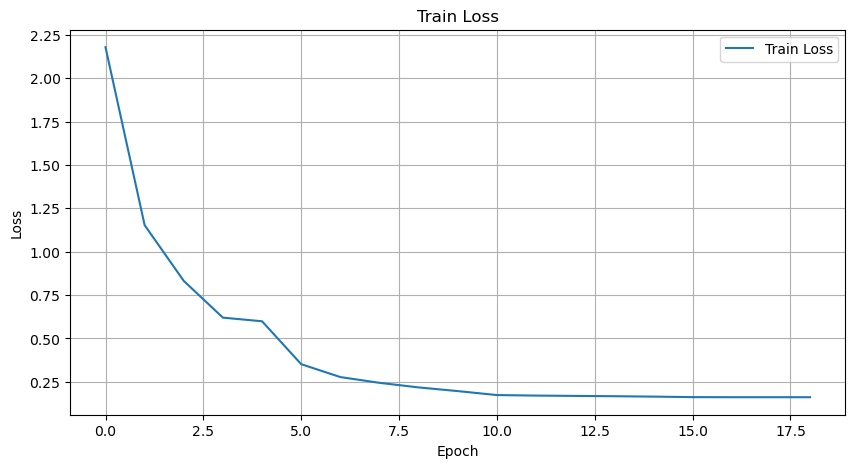

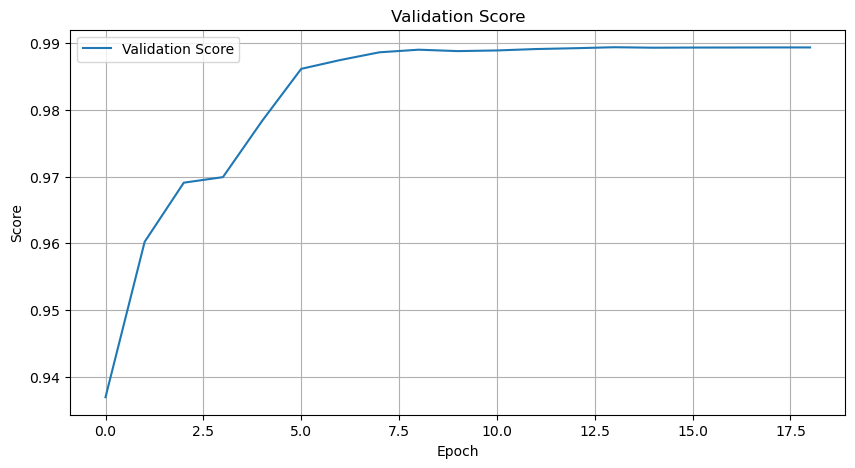

In [58]:
num_epochs = range(len(train_losses))

# 학습 로스 시각화
plt.figure(figsize=(10, 5))
plt.plot(num_epochs, train_losses, label="Train Loss", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss")
plt.legend()
plt.grid()
plt.show()

# 검증 로스 시각화
plt.figure(figsize=(10, 5))
plt.plot(num_epochs, val_scores, label="Validation Score", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Score")
plt.legend()
plt.grid()
plt.show()

그래프를 보면 학습이 안정적으로 진행되었고, 검증 점수도 0.99에 수렴하는 것으로 보아 성능이 매우 좋음

학습 손실이 빠르게 감소한 후 거의 0에 가까워졌고, 검증 점수도 일정하게 유지되는 걸 보면 과적합 없이 잘 학습됨

## 모델 평가

### 평가 함수

In [ ]:
def calculate_iou(box1, box2):
    """
    IoU (Intersection over Union) 계산
    box1, box2: (xmin, ymin, xmax, ymax)
    """
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou = interArea / float(box1Area + box2Area - interArea)
    return iou

def evaluate_map(model, data_loader, iou_threshold=0.5):
    """
    SSD 모델의 Mean Average Precision (mAP) 평가 함수
    - model: 평가할 모델
    - data_loader: 검증 데이터 로더
    - iou_threshold: TP를 결정하는 IoU 기준 (일반적으로 0.5)
    """
    model.eval()
    all_detections = []  # 예측된 바운딩 박스
    all_ground_truths = []  # 실제 바운딩 박스

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            predictions = model(images)

            for target, prediction in zip(targets, predictions):
                gt_boxes = target["boxes"].cpu().numpy()
                gt_labels = target["labels"].cpu().numpy()

                pred_boxes = prediction["boxes"].cpu().numpy()
                pred_labels = prediction["labels"].cpu().numpy()
                pred_scores = prediction["scores"].cpu().numpy()

                all_ground_truths.append((gt_boxes, gt_labels))
                all_detections.append((pred_boxes, pred_labels, pred_scores))

    return compute_map(all_ground_truths, all_detections, iou_threshold)

def compute_map(ground_truths, detections, iou_threshold):
    """
    Mean Average Precision (mAP) 계산 함수
    - ground_truths: 실제 바운딩 박스 리스트
    - detections: 예측된 바운딩 박스 리스트
    - iou_threshold: TP 판단 기준
    """
    aps = []

    # 클래스별 AP 계산
    for class_id in range(1, 3):  # SSD에서는 보통 1부터 시작 (고양이: 1, 개: 2)
        all_gt_boxes = []
        all_pred_boxes = []
        all_scores = []
        num_gt_boxes = 0

        for gt, pred in zip(ground_truths, detections):
            gt_boxes, gt_labels = gt
            pred_boxes, pred_labels, pred_scores = pred

            gt_mask = gt_labels == class_id
            pred_mask = pred_labels == class_id

            gt_boxes = gt_boxes[gt_mask]
            pred_boxes = pred_boxes[pred_mask]
            pred_scores = pred_scores[pred_mask]

            all_gt_boxes.extend(gt_boxes)
            all_pred_boxes.extend(pred_boxes)
            all_scores.extend(pred_scores)
            num_gt_boxes += len(gt_boxes)

        # Precision-Recall Curve 계산
        precision, recall = compute_precision_recall(all_gt_boxes, all_pred_boxes, all_scores, num_gt_boxes, iou_threshold)
        ap = compute_ap(precision, recall)
        aps.append(ap)

    return np.mean(aps)  # 모든 클래스의 AP 평균값

def compute_precision_recall(gt_boxes, pred_boxes, scores, num_gt_boxes, iou_threshold):
    """
    Precision-Recall Curve 계산
    """
    if len(pred_boxes) == 0:
        return [0], [0]

    sorted_indices = np.argsort(-np.array(scores))
    pred_boxes = np.array(pred_boxes)[sorted_indices]

    tp = np.zeros(len(pred_boxes))
    fp = np.zeros(len(pred_boxes))

    matched = set()
    for i, pred_box in enumerate(pred_boxes):
        best_iou = 0
        best_gt_idx = -1
        for j, gt_box in enumerate(gt_boxes):
            if j in matched:
                continue
            iou = calculate_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = j

        if best_iou > iou_threshold:
            tp[i] = 1
            matched.add(best_gt_idx)
        else:
            fp[i] = 1

    tp = np.cumsum(tp)
    fp = np.cumsum(fp)

    recall = tp / (num_gt_boxes + 1e-6)
    precision = tp / (tp + fp + 1e-6)

    return precision, recall

def compute_ap(precision, recall):
    """
    Average Precision (AP) 계산
    """
    recall = np.concatenate(([0], recall, [1]))
    precision = np.concatenate(([0], precision, [0]))

    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = max(precision[i - 1], precision[i])

    indices = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[indices + 1] - recall[indices]) * precision[indices + 1])
    return ap

### 평가 실행

In [71]:
# 모델 로드
model = get_model()
model.load_state_dict(torch.load('best_SSD_model.pth'))

map_05 = evaluate_map(model, val_loader, iou_threshold=0.5)
map_075 = evaluate_map(model, val_loader, iou_threshold=0.75)
map_09 = evaluate_map(model, val_loader, iou_threshold=0.9)

print(f"mAP 0.50: {map_05:.4f}")
print(f"mAP 0.75: {map_075:.4f}")
print(f"mAP 0.90: {map_09:.4f}")

mAP 0.50: 0.9930
mAP 0.75: 0.9178
mAP 0.90: 0.3798


기준이 0.9일때 성능이 급격하게 떨어짐

이는 박스의 위치가 미세하게 차이가 나서일 확률이 높음

## 테스트

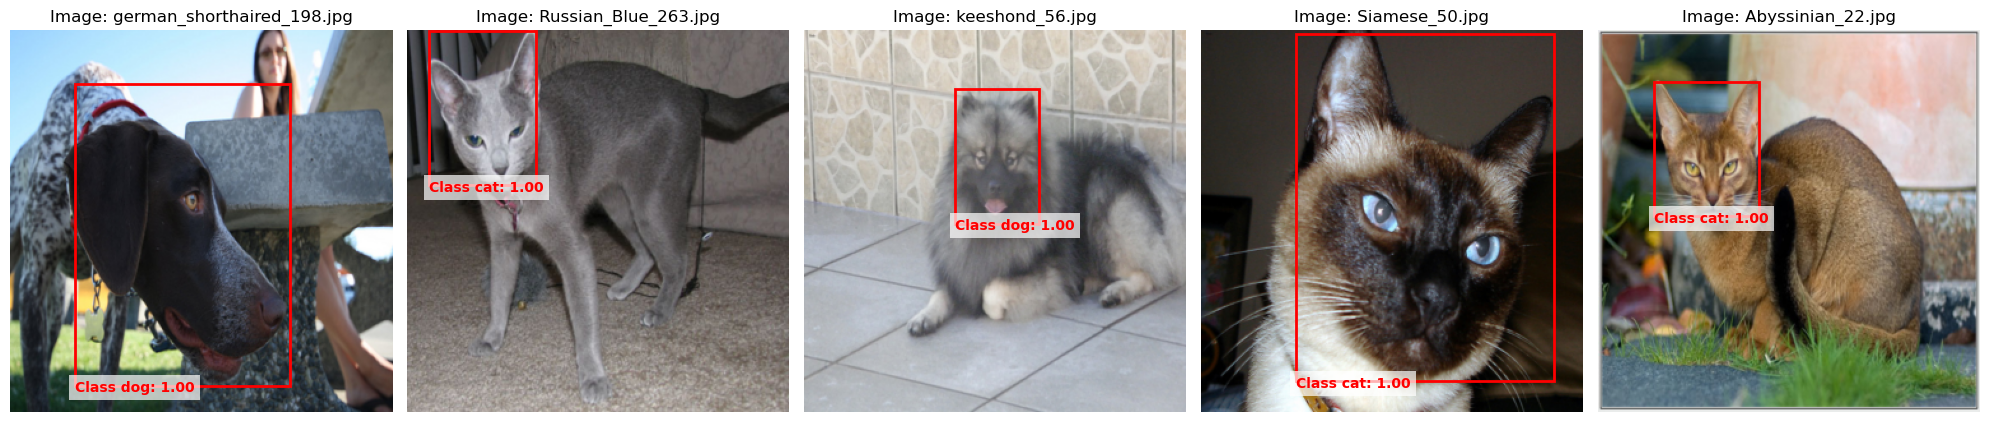

In [65]:
import random

# 모델 로드
model = get_model()
model.load_state_dict(torch.load('best_SSD_model.pth'))
model.eval()

# 랜덤한 테스트 이미지 인덱스 선택 (5개)
num_images = 5
random_indices = random.sample(range(len(test_dataset)), num_images)

fig, axes = plt.subplots(1, num_images, figsize=(num_images * 4, 6))

for idx, img_index in enumerate(random_indices):
    # 테스트 이미지 가져오기
    image, img_name = test_dataset[img_index]
    image = image.to(device).unsqueeze(0)  # 배치 차원 추가

    # 모델 예측 수행
    with torch.no_grad():
        prediction = model(image)

    # 예측 결과 정리
    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()
    pred_labels = prediction[0]['labels'].cpu().numpy()

    # 이미지 변환 (Tensor → NumPy)
    image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    image_np = np.clip(image_np, 0, 1)

    # 결과 시각화
    ax = axes[idx] if num_images > 1 else axes
    ax.imshow(image_np)

    # 신뢰도 0.5 이상인 Bounding Box만 표시
    for bbox, score, label in zip(pred_boxes, pred_scores, pred_labels):
        if score > 0.5:
            xmin, ymin, xmax, ymax = bbox
            
            label_str = ('cat' if label == 1 else 'dog')

            # 박스 그리기
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # 라벨 텍스트 표시
            ax.text(xmin, ymax + 5, f"Class {label_str}: {score:.2f}", 
                    fontsize=10, color='red', fontweight='bold',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    ax.set_title(f"Image: {img_name}")
    ax.axis("off")

plt.tight_layout()
plt.show()

그러나 테스트 이미지에서의 성능을 보면 기존의 목표를 잘 완수 하는 것을 알 수 있음

더욱 더 정밀한 박스 위치를 위해서라면 튜닝을 더 할 수 있겠지만

목표는 완수 했고 시간도 별로 남지 않았기 때문에 아쉽지만 이정도로 만족함